<a href="https://colab.research.google.com/github/jchen8000/DemystifyingLLMs/blob/main/5_Fine-Tuning/LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. Pre-Training

## 5.3 Low-Rank Adaptation (LoRA)

This script is tested on Google Colab with T4 GPU. This script uses the HuggingFace datasets, as a prerequisite you need a HuggingFace account and obtain a access token, see https://huggingface.co/docs/hub/security-tokens. You should add the token to Colab Secrets as HF_TOKEN to run this script.


In [ ]:
%pip install \
  numpy==2.0.2 \
  pandas==2.2.2 \
  matplotlib==3.10.0 \
  torch==2.9.0+cu126 \
  torchvision==0.24.0 \
  torchaudio==2.9.0 \
  datasets==4.0.0 \
  sentencepiece==0.2.1 \
  transformers==4.57.3 \
  accelerate==1.12.0 \
  peft==0.18.0 \
  rouge_score==0.1.2


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
from datasets import load_dataset, Dataset
from transformers import T5Tokenizer
from transformers import T5ForConditionalGeneration
from transformers import TrainingArguments
from transformers import Trainer
from transformers import GenerationConfig
from rouge_score import rouge_scorer
from peft import LoraConfig, get_peft_model, TaskType
import warnings

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
warnings.filterwarnings('ignore')

### Load FLAN-T5 Base model

In [ ]:
model_name = 'google/flan-t5-base'
lora_model_name = 'outputs/flan-t5-base_lora'
def load_model(model_name):
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name, torch_dtype=torch.bfloat16)
    return tokenizer, model

tokenizer, model = load_model(model_name)
total_parameter = sum(p.numel() for p in model.parameters())
print(f"Parameters of the model: {total_parameter:,}")

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Parameters of the model: 247,577,856


### Load TweetSum Dataset

https://github.com/sarahaman/CIS6930_TweetSum_Summarization

Make sure the three files in the datasets folder:

*  tweetsum_train.csv
*  tweetsum_valid.csv
*  tweetsum_test.csv

In [ ]:
import os
import requests
from datasets import load_dataset

# Folder and file setup
folder = "datasets"
files = {
    "train": "tweetsum_train.csv",
    "validation": "tweetsum_valid.csv",
    "test": "tweetsum_test.csv"
}
base_url = "https://raw.githubusercontent.com/jchen8000/DemystifyingLLMs/refs/heads/main/5_Fine-Tuning/datasets"

# Create folder if it doesn't exist
if not os.path.exists(folder):
    os.makedirs(folder)
    print(f"Created folder: {folder}")

# Download missing files
for split, filename in files.items():
    file_path = os.path.join(folder, filename)
    if not os.path.exists(file_path):
        url = f"{base_url}/{filename}"
        print(f"Downloading {filename} from {url}...")
        response = requests.get(url)
        if response.status_code == 200:
            with open(file_path, "wb") as f:
                f.write(response.content)
            print(f"Saved {filename} to {file_path}")
        else:
            print(f"Failed to download {filename}. Status code: {response.status_code}")

# Load dataset
tweetsum = load_dataset("csv", data_files={split: os.path.join(folder, filename) for split, filename in files.items()})
print(tweetsum)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['inputs', 'summaries'],
        num_rows: 869
    })
    validation: Dataset({
        features: ['inputs', 'summaries'],
        num_rows: 108
    })
    test: Dataset({
        features: ['inputs', 'summaries'],
        num_rows: 110
    })
})


### Tokenize the dataset

In [ ]:
def tokenize_function(example):
  prompt = ["Summarize: " + s for s in example['inputs']]
  example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
  example['labels'] = tokenizer(example['summaries'], padding="max_length", truncation=True, return_tensors="pt").input_ids
  return example

Take a subset of the original dataset, in order to run the fine-tuning on the limited resources (single GPU, etc.)

In [ ]:
tokenized_datasets = tweetsum.map(tokenize_function, batched=True)
print(tokenized_datasets)

Map:   0%|          | 0/869 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/110 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['inputs', 'summaries', 'input_ids', 'labels'],
        num_rows: 869
    })
    validation: Dataset({
        features: ['inputs', 'summaries', 'input_ids', 'labels'],
        num_rows: 108
    })
    test: Dataset({
        features: ['inputs', 'summaries', 'input_ids', 'labels'],
        num_rows: 110
    })
})


### Preliminary evaluation by human assessment

In [ ]:
def generate_output(tokenizer, model, input_text, max_length=200):
    # Tokenize the input text and generate the model's output
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    outputs = model.generate(
        input_ids=input_ids,
        generation_config=GenerationConfig(max_new_tokens=200, num_beams=1) )

    # Decode the generated tokens to a string
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response


Produce the output on the randomly selected data samples:

In [ ]:
for item in random.choices(list(tokenized_datasets['test']), k = 5):
    prompt = "Summarize: " + item['inputs']
    output = generate_output(tokenizer, model, prompt)
    print("Prompt:", prompt)
    print("Target:", item['summaries'])
    print("Predict:", output)
    print()

Prompt: Summarize: VirginTrains Can you give Coach C on the 1820 Euston departure strobe lighting? This is the party carriage! BrighterAwards <BR> Glow sticks as well? MW <BR> VirginTrains Only balloon animals. Can you provide the fun? Thats what Virgin is known for! <LINK> <BR> Ahhh mannn, is it a hen party? MW <BR> VirginTrains No, just a corporate awards ceremony. You would make our day if you put strobe lighting in Coach C. Just about to leave Stoke, make our day! <BR> Ill be honest, Im not sure theres enough time. However, flashlights on your phone, you know the rest! MW <BR> VirginTrains This is why we need you to provide the fun <LINK> <BR> VirginTrains The people have spoken! <LINK> <BR> Oh my days, when the alcohol kicks in MW <BR> VirginTrains Kicked in an hour ago, we still need your help! <BR> Im on my way Jake. Get me a seat ready! MW <BR> VirginTrains Coach C. Ill buy you a gin and tonic! <BR> Dont drink Gin, Jake. If theres a cider going spare, Im there. After my shift o

Token indices sequence length is longer than the specified maximum sequence length for this model (641 > 512). Running this sequence through the model will result in indexing errors


Prompt: Summarize: HPSupport Problems with Envy 7640 printer, set as default. HP doctor fixes problems, and then it doesnt work again. Updated drivers. <BR> Hey, Thanks for reaching out. I would love to help! Is there any error message that shows up on your printer or on your computer? .12 <BR> Send us a direct message by clicking on the link below. Cheers Mat 22 <LINK> <BR> HPSupport Cant get it to print at all from one computer. Frustrating ready to take it back. <LINK> <BR> Hi Josey, thanks for tweeting, I see from your tweet that you get User intervention required message while printing from your printer, 12 <BR> follow steps from this document <LINK> reply in direct message <LINK> <BR> HPSupport I have followed most of the steps in the document I currently have at least 6 hours troubleshooting the HP Envy printer. It should be plug and play way too complicated. <BR> HPSupport I have followed most of the steps in the document I currently have at least 6 hours troubleshooting the HP

### Fine-tuning with LoRA

In [ ]:
rank = 16
lora_config = LoraConfig(
    r=rank,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM  #FLAN-T5
)

In [ ]:
lora_model = get_peft_model(model, lora_config)
total_parameter = sum(p.numel() for p in lora_model.parameters())
lora_parameter = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_parameter:,}")
print(f"LoRA Parameters: {lora_parameter:,}; Percentage: {lora_parameter/total_parameter}")

Total Parameters: 249,347,328
LoRA Parameters: 1,769,472; Percentage: 0.007096414524241463


In [ ]:
# print(lora_model)

In [ ]:
max_steps = 300

lora_training_args = TrainingArguments(
    learning_rate=1e-3,
    auto_find_batch_size=True,
    logging_steps=1,
    max_steps=max_steps,
    report_to="none",
    output_dir = 'outputs' )

lora_triner = Trainer(
    model=lora_model,
    args=lora_training_args,
    train_dataset=tokenized_datasets['train'],
    )

lora_triner.train()

Step,Training Loss
1,43.000000
2,42.250000
3,37.750000
4,35.750000
5,33.250000
6,31.375000
7,28.750000
8,26.750000
9,24.750000
10,23.125000


TrainOutput(global_step=300, training_loss=2.068942057291667, metrics={'train_runtime': 694.4886, 'train_samples_per_second': 3.456, 'train_steps_per_second': 0.432, 'total_flos': 1652322450014208.0, 'train_loss': 2.068942057291667, 'epoch': 2.75})

In [ ]:
lora_triner.save_model(lora_model_name)

### Visualize the fine-tuning

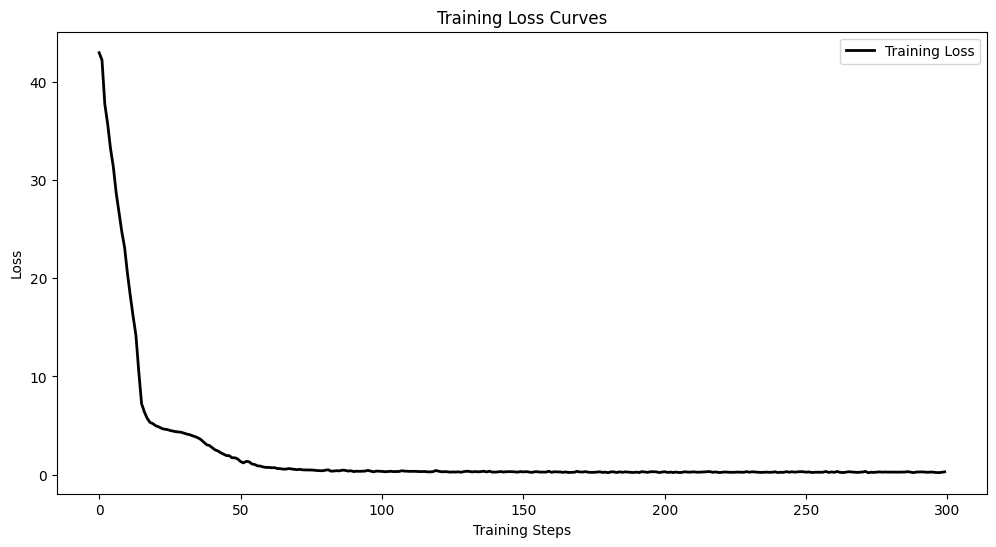

In [ ]:
log_history = lora_triner.state.log_history
df = pd.DataFrame(log_history)

if 'loss' in df.columns:
    df_filtered = df.dropna(subset=['loss'], how='all')
    df_filtered.reset_index(drop=True, inplace=True)

    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered['loss'], lw=2, c='k', label='Training Loss')

    plt.title('Training Loss Curves')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("outputs/flan-t5-base_lora.svg", format="svg", dpi=150, transparent=True, bbox_inches='tight')
    plt.show()

### Evaluation on the fine-tuned model

Load the saved fine-tuned model:

In [ ]:
from peft import PeftModel, PeftConfig
tokenizer, base_model = load_model(model_name)
peft_model = PeftModel.from_pretrained(base_model,
                                       lora_model_name,
                                       torch_dtype=torch.bfloat16,
                                       is_trainnable=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


ROUGE Scores:

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
for item in random.choices(list(tokenized_datasets['test']), k = 5):
    prompt = "Summarize: " + item['inputs']
    output = generate_output(tokenizer, peft_model, prompt)
    scores = scorer.score(item['summaries'], output)
    print("Target:", item['summaries'])
    print("Predict:", output)
    print(scores)
    print()

Token indices sequence length is longer than the specified maximum sequence length for this model (744 > 512). Running this sequence through the model will result in indexing errors


Target: Customer is waiting over 3 weeks for compensation that was promised . Agent informed that he will get back to him with further  information.
Predict: Customer is complaining about the delay in paying mandatory compensation. Agent is asking for an additional gesture of goodwill.
{'rouge1': Score(precision=0.2631578947368421, recall=0.21739130434782608, fmeasure=0.23809523809523808)}

Target: Customer is complaining about the new updates IOS11 and can't even use some apps on phone. Agent asks to send a DM and work from there URL.
Predict: Customer is complaining about the new update ios11 sucks.
{'rouge1': Score(precision=0.8888888888888888, recall=0.2857142857142857, fmeasure=0.43243243243243246)}

Target: Customer is complaining about issues with claiming train delay compensation. Agent states to claim the compensation for the entire journey.
Predict: Customer is complaining about the delay on both companies service.
{'rouge1': Score(precision=0.6, recall=0.3, fmeasure=0.4)}

T